##### Mise en forme des dossiers de travail

In [1]:
!python --version

Python 3.9.16


In [2]:
import os
if os.getcwd().split('\\')[-1]!='OC-DS-P6-Classifiez-automatiquement-des-biens-de-consommation':
    # si valeur diff 'C:\\Users\\...\\Projets\\P6\\OC-DS-P6-Classifiez-automatiquement-des-biens-de-consommation'
    os.chdir('OC-DS-P6-Classifiez-automatiquement-des-biens-de-consommation')

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import tensorflow as tf
#import tensorflow_core as tfc
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))#tf.config.list_physical_devices('GPU')
print('la version de tensorflow est: ', tf.__version__)
#print('la version de tensorflow_core est: ', tfc.__version__)

In [ ]:
import pandas as pd
df = pd.read_csv('data/source/flipkart_com-ecommerce_sample_1050.csv')   

df['cat_1'] = df.product_category_tree.str.replace('\\[|\\"','',regex=True).str.split(" >> ",expand = True)[0]\
.apply(lambda x:x.replace(' ','_'))

In [ ]:
IMAGE_SIZE = (224,224)
batch_size = 32
epochs = 75

train_path = 'data/cleaned/Images/train'
test_path  = 'data/cleaned/Images/test'
all_path   = 'data/cleaned/Images/all'

## Utilisation du VGG-16 pré-entraîné

## Transfert Learning

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [ ]:
VGG16(weights="imagenet", input_shape=(224, 224, 3)).summary()

In [ ]:
model.summary()

In [ ]:
# On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches :
for layer in model.layers:
   layer.trainable = False

In [ ]:
import glob2
train_folders = glob2.glob(train_path+'/*')

# Récupérer la sortie de ce réseau et ajout d'une couche de Flatten 
flat1 = Flatten()(model.output)

class1 = Dense(1024, activation='relu')(flat1)
class2 = Dense(1024, activation='relu')(class1)

# Ajouter la nouvelle couche fully-connected pour la classification à 7 classes
predictions = Dense(len(train_folders), activation='softmax')(class2)

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)

In [ ]:
new_model.summary()

In [ ]:
# Compiler le modèle 
from keras import optimizers
adam = optimizers.Adam()

new_model.compile(loss="categorical_crossentropy", 
                  optimizer= adam, #optimizers.SGD(lr=0.0001, momentum=0.9), # adam
                  metrics=["accuracy"])




## Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


train_image_generator = ImageDataGenerator(
    rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           color_mode = "rgb",
                                                           directory= train_path,
                                                           #shuffle=True,
                                                           target_size=IMAGE_SIZE, 
                                                           class_mode='categorical',
                                                           #save_to_dir='data/cleaned/Images/augmented images train/',
                                                           #save_prefix='augm_',
                                                            #save_format='jpg',
                                                          )

val_data_gen = test_image_generator.flow_from_directory(batch_size = batch_size, 
                                                              directory = test_path, 
                                                              color_mode = 'rgb',
                                                              target_size=IMAGE_SIZE,
                                                              class_mode='categorical')


## Entrainement

In [16]:
tf.__version__

'2.3.0'

In [17]:
%%time
with tf.device('/device:GPU:0'):
  #code here: tf data and model
    new_model.fit_generator(train_data_gen, 
                        epochs=epochs,  # one forward/backward pass of training data
                        #steps_per_epoch=700 //batch_size,  # number of images comprising of one epoch
                        validation_data=val_data_gen, # Or validation_data=valid_generator
                        # validation_steps= 350 //batch_size
                        verbose = 1
                           )


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/75
22/22 [==============================] - 58s 3s/step - loss: 4.8242 - accuracy: 0.2257 - val_loss: 1.2804 - val_accuracy: 0.4914
Epoch 2/75
19/22 [========================>.....] - ETA: 5s - loss: 1.1821 - accuracy: 0.5629

KeyboardInterrupt: 

In [ ]:
# enreguistre les poids
new_model.save('/data.result/transfert_learning')

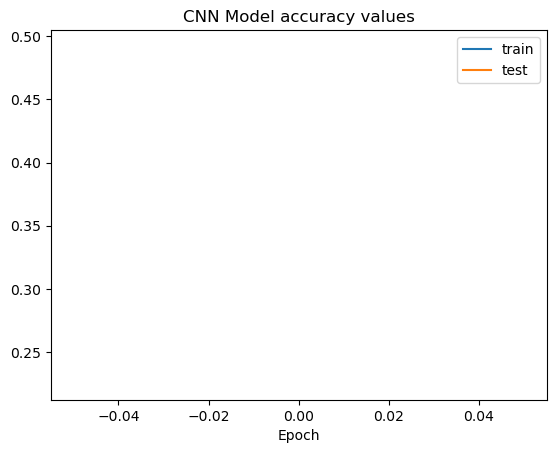

In [18]:
import matplotlib.pyplot as plt
plt.plot(new_model.history.history['accuracy'],label='train')
plt.plot(new_model.history.history['val_accuracy'],label='test')
plt.title('CNN Model accuracy values')
plt.xlabel('Epoch')
plt.legend(loc='upper right')